# UFO Sighitngs Project

### By Frankie Contreras

With the enablement of new technology and ability to capture any moment in time has allowed for people to share with one another their interesting experiences through life. One phenomena that seems to be occurring more frequently is UFO sightings. The purpose of this project is to analyze UFO sighting across the United States in intricate detail via python (numpy, pandas, scikit-learn ML) to allow interested individuals to leverage these findings in search for extraterrestrial life. Some finding include popular locations for UFO activity, certain seasonal trends and patterns, and more.

In [123]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import geopandas
import mpl_toolkits
import descartes 
import sys
import warnings
from shapely.geometry import Point, Polygon
from pygeocoder import Geocoder
from mpl_toolkits.basemap import Basemap
from scipy.stats import gaussian_kde
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering
from nltk.corpus import stopwords
import os  

import sklearn as sk
import sklearn.tree as tree

from IPython.display import Image  
import pydotplus



%matplotlib inline
%autosave 0
plt.style.use('seaborn-whitegrid')
warnings.filterwarnings("ignore")

Autosave disabled


### Data Set Description

The main data set consisted on UFO sightings restricted to the United States. Variables such as date, state, city, shape, duration, and geophracial coordinates were all analyzed. Many csv files were analyzed to correlate with UFO sightings, where Nuclear Power plant locations showed some correlation and shown in this notebook

In [124]:
df = pd.read_csv("UFO_sightings_complete.csv")

In [125]:
Ufo_DF = df.copy()

In [126]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [127]:
df = df[df.country == 'us'] #sticking to only the US

In [6]:
df.head()

,datetime,city,state,country,shape,duration(seconds),duration (hours/min),comments,date posted,latitude,longitude,Unnamed: 11
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111,NaN
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833,NaN
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611,NaN
5,10/10/1961 19:00,bristol,tn,us,sphere,300,5 minutes,My father is now 89 my brother 52 the girl wit...,4/27/2007,36.595,-82.188889,NaN
7,10/10/1965 23:45,norwalk,ct,us,disk,1200,20 minutes,A bright orange color changing to reddish colo...,10/2/1999,41.1175,-73.408333,NaN


## Data Cleaning

In [128]:
df.shape

(70293, 12)

In [129]:
df.isna().sum()

datetime                    0
city                        0
state                       0
country                     0
shape                    2229
duration(seconds)           1
duration (hours/min)     2223
comments                   28
date posted                 0
latitude                    0
longitude                   0
Unnamed: 11             70293
dtype: int64

In [130]:
df.isna().sum().sum()

74774

In [131]:
#unncessary column and have and do not need duration hors/min when we have seconds
df.drop(['Unnamed: 11', 'duration (hours/min)'], axis=1, inplace=True) 

In [132]:
#can drop rest of NA's
df.dropna(inplace=True)

In [133]:
#Date time is a string, need to convert to datetime form (unique values)
def datetime_conversion(series):
    #MAP DATETIMES FROM UNIQUE VALUES
    datetimes = {t:pd.to_datetime(t, errors='coerce') for t in series.unique()}
    return series.map(datetimes)

In [134]:
#NOTE THIS TAKES ~30s to 2 mins 
for col in ["datetime"]:
    df[col] = datetime_conversion(df[col])

In [135]:
df.head()

,datetime,city,state,country,shape,duration(seconds),comments,date posted,latitude,longitude
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
3,1956-10-10 21:00:00,edna,tx,us,circle,20,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,1960-10-10 20:00:00,kaneohe,hi,us,light,900,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611
5,1961-10-10 19:00:00,bristol,tn,us,sphere,300,My father is now 89 my brother 52 the girl wit...,4/27/2007,36.595,-82.188889
7,1965-10-10 23:45:00,norwalk,ct,us,disk,1200,A bright orange color changing to reddish colo...,10/2/1999,41.1175,-73.408333


In [136]:
#issues with shape becuse of "shape" python command
df.rename(columns={'shape':'Shape'}, inplace=True) 

In [137]:
 #Duration(seconds) was a str format, need numeric
df['duration(seconds)'] = pd.to_numeric(df['duration(seconds)'],errors='coerce')


In [138]:
#Hours column for more convience
df['duration_hrs'] = df['duration(seconds)'].apply(lambda x: x/3600)

In [139]:
df.head()

,datetime,city,state,country,Shape,duration(seconds),comments,date posted,latitude,longitude,duration_hrs
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700.0,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111,0.750000
3,1956-10-10 21:00:00,edna,tx,us,circle,20.0,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833,0.005556
4,1960-10-10 20:00:00,kaneohe,hi,us,light,900.0,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611,0.250000
5,1961-10-10 19:00:00,bristol,tn,us,sphere,300.0,My father is now 89 my brother 52 the girl wit...,4/27/2007,36.595,-82.188889,0.083333
7,1965-10-10 23:45:00,norwalk,ct,us,disk,1200.0,A bright orange color changing to reddish colo...,10/2/1999,41.1175,-73.408333,0.333333


In [140]:
#For time series of 1 day analysis
df['Milt_Time'] = df['datetime'].dt.hour

In [141]:
df['Year'] = df['datetime'].dt.year #extracting just the year from datetime

In [142]:
df['Month_Day']=df['datetime'].dt.strftime('%m-%d')  #extracting month and day from datetime

In [143]:
df['M_D_Y']=df['datetime'].dt.strftime('%m-%d-%y')  #extracting month, day, and year from datetime

In [144]:
df['Month']=df['datetime'].dt.strftime('%m').apply(lambda s: s.lstrip('0'))

In [146]:
df.head(2)

,datetime,city,state,country,Shape,duration(seconds),comments,date posted,latitude,longitude,duration_hrs,Milt_Time,Year,Month_Day,M_D_Y,Month
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700.0,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111,0.750000,20.0,1949.0,10-10,10-10-49,10
3,1956-10-10 21:00:00,edna,tx,us,circle,20.0,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833,0.005556,21.0,1956.0,10-10,10-10-56,10


In [101]:
df.dtypes

datetime             datetime64[ns]
city                         object
state                        object
country                      object
Shape                        object
duration(seconds)           float64
comments                     object
date posted                  object
latitude                     object
longitude                   float64
duration_hrs                float64
Milt_Time                   float64
Year                        float64
Month_Day                    object
M_D_Y                        object
Month                        object
dtype: object

In [147]:
df['Month'] = pd.to_numeric(df['Month'],errors='coerce')
df['duration(seconds)'] = pd.to_numeric(df['duration(seconds)'],errors='coerce')
df['Year'] = pd.to_numeric(df['Year'],errors='coerce')
df['latitude'] = df['latitude'].astype('float64')

In [148]:
#Will analyze some seasons
def season(month):
    if month == 1 or month == 2 or month == 12:
            return 'Winter'
    elif month == 3 or month == 4 or month == 5:
            return 'Spring'
    elif month == 6 or month == 7 or month == 8:
            return 'Summer'
    elif month == 9 or month == 10 or month == 11:
        return "Fall"

In [149]:
df['Season'] = df.Month.apply(season)

In [150]:
#To look at binned times for machine learning
def day(time):
    if time in range(0,5):
        return 'Early_Morning'
    elif time in range(6,11):
        return 'Morning'
    elif time in range(12,16):
        return 'Afternoon'
    elif time in range(17,21):
        return 'Evening'
    else:
        return 'Late_Night'

In [151]:
df['bin_time'] = df.Milt_Time.apply(day)

In [152]:
df.comments = df.comments.str.lower()

In [153]:
df['filter_comments'] = df.comments

In [154]:
df.head(2)

,datetime,city,state,country,Shape,duration(seconds),comments,date posted,latitude,longitude,duration_hrs,Milt_Time,Year,Month_Day,M_D_Y,Month,Season,bin_time,filter_comments
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700.0,this event took place in early fall around 194...,4/27/2004,29.883056,-97.941111,0.750000,20.0,1949.0,10-10,10-10-49,10.0,Fall,Evening,this event took place in early fall around 194...
3,1956-10-10 21:00:00,edna,tx,us,circle,20.0,my older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833,0.005556,21.0,1956.0,10-10,10-10-56,10.0,Fall,Late_Night,my older brother and twin sister were leaving ...


In [155]:
from nltk.corpus import stopwords #need to get rid of stop words
stop = stopwords.words('english')

In [156]:
Male = ['male','brother', 'father', 'grandpa', 'son', 'boy', 'dad', 'man', 'husband', 'uncle', 'nephew', 'sir' ]
Female = ['girl', 'sister', 'mum', 'mom', 'woman', 'mother', 'wife', 'woman', 'female', 'niece','madam', 'daughter', 'aunt']

In [157]:
df.filter_comments.astype('str')

0        this event took place in early fall around 194...
3        my older brother and twin sister were leaving ...
4        as a marine 1st lt. flying an fj4b fighter/att...
5        my father is now 89 my brother 52 the girl wit...
7        a bright orange color changing to reddish colo...
8        strobe lighted disk shape object observed clos...
9        saucer zaps energy from powerline as my pregna...
10       round &#44 orange &#44 with what i would say w...
11       silent red /orange mass of energy floated by t...
12                silver disc seen by family and neighbors
13       slow moving&#44 silent craft accelerated at an...
14       green oval shaped light over my local church&#...
15       on october 10&#44 1972 myself&#44my 5yrs.daugh...
16       the ufo was so close&#44 my battery in the car...
17       oh&#44 what a night &#33  two (2) saucer-shape...
20       not sure of the eact month or year of this sig...
22                                    the light chased u

In [158]:
df.dropna(inplace=True)

In [159]:
#Made Dataframe for Femal for gender specific comments
df_Female = df[df.filter_comments.str.contains('|'.join(Female))] 

In [160]:
#Made Dataframe for Male for gender specific comments
df_Male = df[df.filter_comments.str.contains('|'.join(Male))]

### Nuclear Powerplants CSV data cleanup

In [161]:
#Exploring Nuclear Power Plants in the US
df_n = pd.read_csv('Nuclear_Reactor.csv')

In [166]:
df_n.head(2)

,Region,Country,Plant,NumReactor,Latitude,Longitude
3,America - Northern,UNITED STATES OF AMERICA,ARKANSAS ONE,2,35.31032,-93.231289
9,America - Northern,UNITED STATES OF AMERICA,BEAVER VALLEY,2,40.62190,-80.433900


In [162]:
df_n.drop(columns=['FID'], inplace = True)

In [163]:
df_n.drop(df_n.iloc[:, 6:60], axis = 1, inplace=True)

In [164]:
df_n = df_n[df_n.Country=='UNITED STATES OF AMERICA']

In [168]:
df_n.head(2)

,Region,Country,Plant,NumReactor,Latitude,Longitude
3,America - Northern,UNITED STATES OF AMERICA,ARKANSAS ONE,2,35.31032,-93.231289
9,America - Northern,UNITED STATES OF AMERICA,BEAVER VALLEY,2,40.62190,-80.433900


In [169]:
df_n.shape

(85, 6)

In [170]:
df_n.dtypes

Region         object
Country        object
Plant          object
NumReactor      int64
Latitude      float64
Longitude     float64
dtype: object

# Interesting Finding 1

UFO Sightings occur most frequently in the Summer season at 90% from 1950-2014 with it's closest comptitor Fall at ~8%. Time of day showed "late night" hours (9pm-12AM) showed highest UFO activity.

###### Using KNN classifer to find patterns

In [171]:
#KNN
clu = KMeans(n_clusters=3, random_state = 0)

In [172]:
df_ufo = df.copy()

In [173]:
df_ufo.dropna(inplace=True)

In [174]:
df.Shape.value_counts()

light        14184
triangle      6905
circle        6587
fireball      5331
unknown       5002
other         4775
sphere        4484
disk          4483
oval          3221
formation     2098
cigar         1728
changing      1686
flash         1162
rectangle     1119
cylinder      1070
diamond        997
chevron        838
teardrop       628
egg            627
cone           277
cross          211
delta            7
round            2
hexagon          1
pyramid          1
crescent         1
flare            1
changed          1
Name: Shape, dtype: int64

In [49]:
df_ufo.head()

,datetime,city,state,country,Shape,duration(seconds),comments,date posted,latitude,longitude,duration_hrs,Milt_Time,Year,Month_Day,M_D_Y,Month,Season,bin_time,filter_comments
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700.0,this event took place in early fall around 194...,4/27/2004,29.883056,-97.941111,0.750000,20.0,1949.0,10-10,10-10-49,10.0,Fall,Evening,this event took place in early fall around 194...
3,1956-10-10 21:00:00,edna,tx,us,circle,20.0,my older brother and twin sister were leaving ...,1/17/2004,28.978333,-96.645833,0.005556,21.0,1956.0,10-10,10-10-56,10.0,Fall,Late_Night,my older brother and twin sister were leaving ...
4,1960-10-10 20:00:00,kaneohe,hi,us,light,900.0,as a marine 1st lt. flying an fj4b fighter/att...,1/22/2004,21.418056,-157.803611,0.250000,20.0,1960.0,10-10,10-10-60,10.0,Fall,Evening,as a marine 1st lt. flying an fj4b fighter/att...
5,1961-10-10 19:00:00,bristol,tn,us,sphere,300.0,my father is now 89 my brother 52 the girl wit...,4/27/2007,36.595000,-82.188889,0.083333,19.0,1961.0,10-10,10-10-61,10.0,Fall,Evening,my father is now 89 my brother 52 the girl wit...
7,1965-10-10 23:45:00,norwalk,ct,us,disk,1200.0,a bright orange color changing to reddish colo...,10/2/1999,41.117500,-73.408333,0.333333,23.0,1965.0,10-10,10-10-65,10.0,Fall,Late_Night,a bright orange color changing to reddish colo...


In [175]:
#What we do not need or not interested in
df_ufo.drop(columns=['country','datetime', 'city', 'comments', 'date posted', 'duration(seconds)', 'filter_comments', 'Month_Day', 'M_D_Y'], inplace=True)

In [176]:
df_ufo=pd.get_dummies(df_ufo, columns=['Shape', 'state','Season', 'bin_time'])

In [177]:
clu.fit(df_ufo)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [178]:
df_ufo['cluster']=clu.labels_

In [179]:
df_ufo.groupby('cluster').mean() 
#state Pennsylvania has some correlations with the first cluster
#Summer has high correlation with every cluster, but more corrleation with middle cluster and ~16k
#hours duration

,latitude,longitude,duration_hrs,Milt_Time,Year,Month,Shape_changed,Shape_changing,Shape_chevron,Shape_cigar,Shape_circle,Shape_cone,Shape_crescent,Shape_cross,Shape_cylinder,Shape_delta,Shape_diamond,Shape_disk,Shape_egg,Shape_fireball,Shape_flare,Shape_flash,Shape_formation,Shape_hexagon,Shape_light,Shape_other,Shape_oval,Shape_pyramid,Shape_rectangle,Shape_round,Shape_sphere,Shape_teardrop,Shape_triangle,Shape_unknown,state_ak,state_al,state_ar,state_az,state_ca,state_co,state_ct,state_dc,state_de,state_fl,state_ga,state_hi,state_ia,state_id,state_il,state_in,state_ks,state_ky,state_la,state_ma,state_md,state_me,state_mi,state_mn,state_mo,state_ms,state_mt,state_nc,state_nd,state_ne,state_nh,state_nj,state_nm,state_nv,state_ny,state_oh,state_ok,state_or,state_pa,state_pr,state_ri,state_sc,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy,Season_Fall,Season_Spring,Season_Summer,Season_Winter,bin_time_Afternoon,bin_time_Early_Morning,bin_time_Evening,bin_time_Late_Night,bin_time_Morning
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,38.309151,-95.519482,0.482726,15.719759,2004.265082,6.868357,0.000015,0.025009,0.01243,0.025632,0.097676,0.004109,0.000015,0.00313,0.015871,0.000104,0.014789,0.066497,0.0093,0.079060,0.000015,0.017236,0.03112,0.000015,0.210333,0.070813,0.047777,0.000015,0.016598,0.00003,0.066511,0.009315,0.102422,0.074165,0.004806,0.010116,0.009107,0.037335,0.136093,0.021834,0.01381,0.000104,0.00264,0.059466,0.019594,0.003931,0.010531,0.00804,0.03861,0.020306,0.009226,0.013276,0.008440,0.019209,0.012697,0.00841,0.027945,0.015753,0.022398,0.005904,0.007417,0.026996,0.001973,0.005963,0.007595,0.019387,0.011021,0.012089,0.046220,0.035525,0.01114,0.025854,0.036222,0.000371,0.003471,0.01553,0.0027,0.017562,0.053814,0.009493,0.019713,0.004049,0.057819,0.018734,0.00709,0.00267,0.278802,0.200721,0.320171,0.200306,0.067401,0.159826,0.273507,0.433081,0.066185
1,36.116574,-97.924352,15881.703704,13.333333,2001.666667,8.333333,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.333333,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.00000,0.00000,0.333333,0.000000,0.666667,0.000000,0.000000,0.333333,0.333333,0.333333,0.000000
2,33.173730,-101.280238,2150.619048,16.142857,2000.285714,5.857143,0.000000,0.000000,0.00000,0.000000,0.285714,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0000,0.142857,0.000000,0.000000,0.00000,0.000000,0.142857,0.142857,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.285714,0.000000,0.000000,0.000000,0.142857,0.142857,0.000000,0.00000,0.000000,0.00000,0.000000,0.142857,0.142857,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.428571,0.428571,0.142857,0.000000,0.142857,0.142857,0.714286,0.000000


In [201]:
df[df.Year > 1950].groupby('Year').apply(lambda x: x.groupby('Season').\

                                         Season.value_counts().nlargest(1))

Year    Season  Season
1951.0  Summer  Summer       9
1952.0  Summer  Summer      29
1953.0  Summer  Summer      14
1954.0  Summer  Summer      25
1955.0  Summer  Summer      20
1956.0  Summer  Summer      22
1957.0  Summer  Summer      37
1958.0  Summer  Summer      27
1959.0  Summer  Summer      26
1960.0  Summer  Summer      34
1961.0  Summer  Summer      22
1962.0  Summer  Summer      35
1963.0  Summer  Summer      50
1964.0  Summer  Summer      49
1965.0  Summer  Summer     101
1966.0  Summer  Summer      91
1967.0  Summer  Summer      80
1968.0  Summer  Summer     107
1969.0  Summer  Summer      76
1970.0  Summer  Summer      57
1971.0  Summer  Summer      48
1972.0  Summer  Summer      77
1973.0  Summer  Summer      90
1974.0  Summer  Summer     121
1975.0  Summer  Summer     142
1976.0  Summer  Summer     140
1977.0  Summer  Summer     115
1978.0  Summer  Summer     154
1979.0  Summer  Summer      96
1980.0  Summer  Summer     102
1981.0  Summer  Summer      75
1982.0  Summer  

In [181]:
#Counts for each season
season = df[df.Year > 1950].groupby('Year').apply(lambda x: x.groupby('Season').Season.value_counts().nlargest(1))
df_season = pd.DataFrame(season)
df_season.rename(columns={'Season': 'Season_counts'})
df_season.droplevel(level=1)
df_sea1=df_season.unstack(level=1)
print('Fall:', df_sea1.Season.Fall.value_counts().sum())
print('Winter:', df_sea1.Season.Winter.value_counts().sum())
print('Summer:', df_sea1.Season.Summer.value_counts().sum())
print('Spring : 0')


Fall: 5
Winter: 1
Summer: 58
Spring : 0


In [182]:
#Making a dataframe and adding season %
season_df =pd.DataFrame({'Season_counts': [58,5,1,0]}, index = ['Summer', 'Fall', 'Winter', 'Spring'])
season_df = season_df.reset_index()
season_df =season_df.rename(columns={'index':'seasons'})
season_df['Season %'] = season_df.Season_counts.apply(lambda x: x/64 *100)
season_df

,seasons,Season_counts,Season %
0,Summer,58,90.6250
1,Fall,5,7.8125
2,Winter,1,1.5625
3,Spring,0,0.0000


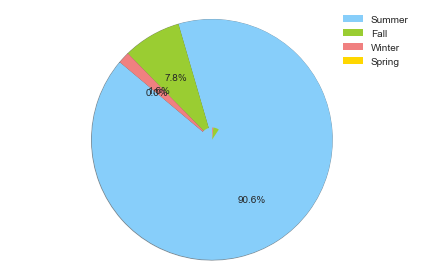

In [183]:
sizes = season_df['Season %']
labels = season_df['seasons']
colors = ['lightskyblue', 'yellowgreen', 'lightcoral', 'gold']
explode=(0,0,0,0)
plt.pie(sizes, colors=colors, explode=explode, radius=10, \
        autopct='%1.1f%%', shadow=True, startangle=140)
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90)
plt.legend(patches,labels, loc='best')
plt.axis('equal')
plt.tight_layout()
plt.show()

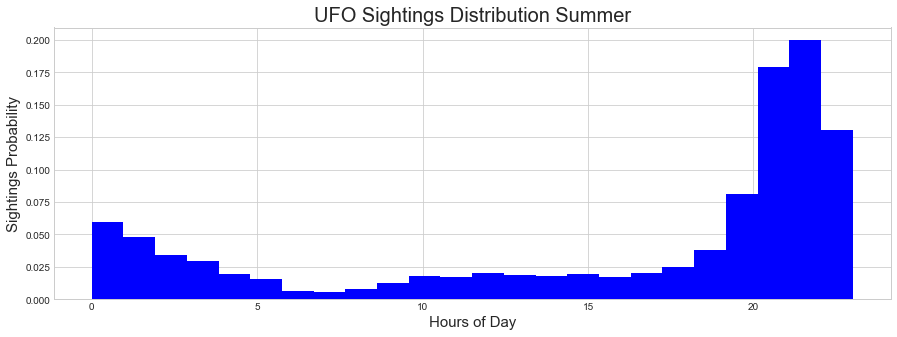

In [184]:
#If wanting to explore further we can see what time during the summer is most frquent
df.Milt_Time[df.Season == 'Summer'].hist(bins=24, color='blue', normed=True, figsize=(15,5))
plt.xlabel('Hours of Day', fontsize =15)
plt.ylabel("Sightings Probability", fontsize=15)
plt.title("UFO Sightings Distribution Summer", fontsize =20)
plt.show()

## Managerial Suggestion

UFO researchers and ufologist should adjust their resources based on seasonality and time of day. By focusing on Summer and the 
late hours of the days, your odds increase significantly in capturing a sighting as well as for the opportunity to save time and money. 

## Interesting Finding 2

When investigating high surveillance areas, such as airports and nuclear powerplants, it was concluded that high clustering of sightings appeared around nuclear power plant locations.

Data found at: https://www.kaggle.com/liananapalkova/nuclear-power-plants

In [185]:
os.environ['PROJ_LIB'] = r'C:\Users\fcont\Anaconda3\Library\share'

In [186]:
df_ufo.corrwith(df_n.NumReactor).nlargest(10)

state_ky            0.249250
state_ak            0.249250
Shape_sphere        0.235791
state_fl            0.228789
Shape_triangle      0.195366
Shape_light         0.179066
bin_time_Evening    0.168115
state_ga            0.144249
state_va            0.100393
state_sc            0.100393
dtype: float64

In [187]:
df_ufo.corrwith(df_n.Latitude).nlargest(10)

bin_time_Early_Morning    0.278836
Shape_disk                0.199657
state_nm                  0.187322
state_mi                  0.171715
Shape_cylinder            0.168348
state_ga                  0.138842
state_nv                  0.134556
state_wa                  0.118889
Shape_other               0.116839
Shape_triangle            0.108863
dtype: float64

In [188]:
df_ufo.corrwith(df_n.Longitude).nlargest(10)

bin_time_Afternoon    0.202031
state_va              0.177390
Shape_disk            0.158347
state_wi              0.150918
state_pa              0.147439
Shape_other           0.142769
longitude             0.131755
duration_hrs          0.127370
state_fl              0.113274
state_sc              0.106794
dtype: float64

No handles with labels found to put in legend.


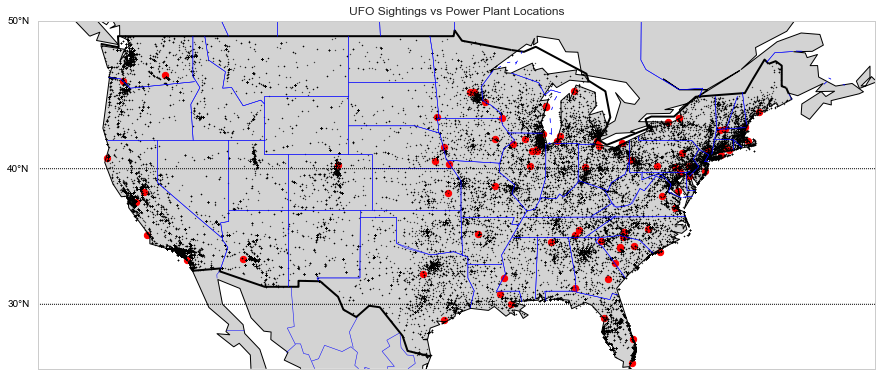

In [189]:
fig = plt.figure(figsize=(15,12))
m = Basemap(projection='mill',
           llcrnrlat = 25 ,     
           urcrnrlat = 50,
           llcrnrlon = -130,
           urcrnrlon = -60,
           resolution = 'c')
m.drawcoastlines()
m.drawcountries(linewidth=2)
m.drawstates(color='b')
m.drawparallels(np.arange(-90,90,10), labels=[True, False, False, False])
#m.bluemarble()
plt.title('UFO Sightings vs Power Plant Locations')
#xpt, ypt = map(x,y)
y = df_n.Latitude.values
x = df_n.Longitude.values
xf = df.longitude.values
yf = df.latitude.values
m.scatter(x,y, latlon=True, c='red', marker='o', s=40)
m.scatter(xf,yf, latlon=True, c='black', marker='o', s=0.1)
m.fillcontinents(color='lightgray',zorder=0)
plt.legend()
plt.show()

In [190]:
#Looking a little closer at sphere corrleation 
df_sphere = df[df.Shape =='sphere']

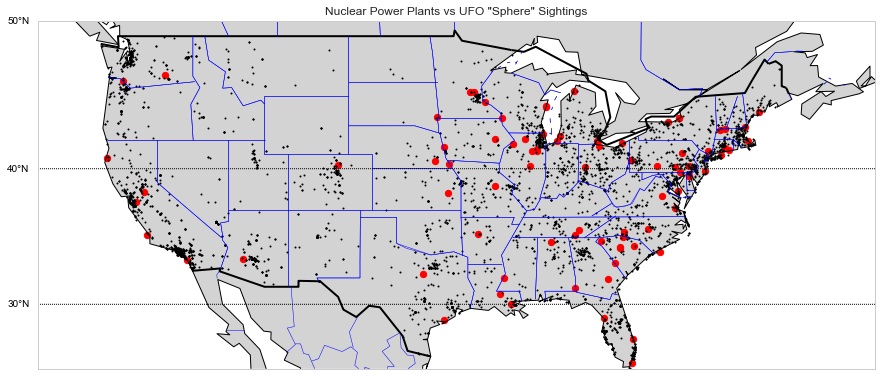

In [191]:
fig = plt.figure(figsize=(15,12))
m = Basemap(projection='mill',
           llcrnrlat = 25 ,     
           urcrnrlat = 50,
           llcrnrlon = -130,
           urcrnrlon = -60,
           resolution = 'c')
m.drawcoastlines()
m.drawcountries(linewidth=2)
m.drawstates(color='b')
m.drawparallels(np.arange(-90,90,10), labels=[True, False, False, False])
#m.bluemarble()
plt.title('Nuclear Power Plants vs UFO "Sphere" Sightings')
#xpt, ypt = map(x,y)
y = df_n.Latitude.values
x = df_n.Longitude.values
xf = df_sphere.longitude.values
yf = df_sphere.latitude.values
m.scatter(x,y, latlon=True, c='red', marker='o', s=40)
m.scatter(xf,yf, latlon=True, c='black', marker='o', s=1)
m.fillcontinents(color='lightgray',zorder=0)
plt.show()

## Managerial Suggestion

Knowing a lot of the sightings occur within radius of nuclear power plants, officials can dedicate resources to investigate why these sightings are occurring so close to the plants. This may shed light on any intrusions of UFOs into the area and give the public more conclusions on these sightings.



## Interesting Finding Three

After the significant spike in 1997/1998, holidays, especially 4th July, had the most frequent sighting days whereas before the significant spike holidays were less prevelant, where the most popular day was 06/01 (29/66) years.

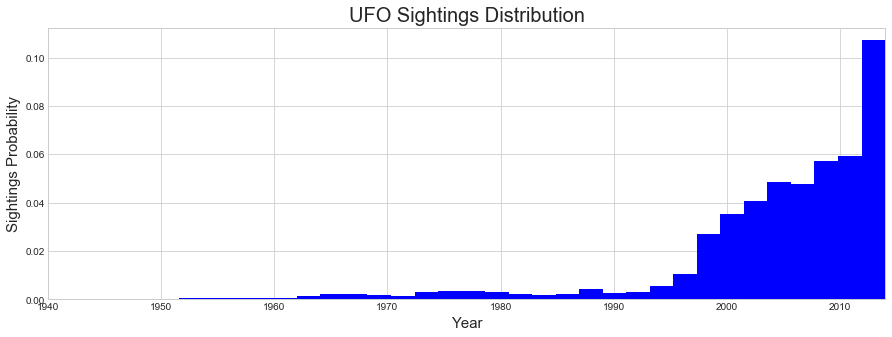

In [72]:
#A significant spike in roughly 1997/1998 in UFO sightings in the US
df_ufo.Year.hist(bins=50, color='blue', normed=True, figsize=(15,5))
plt.xlabel('Year', fontsize =15)
plt.xlim(1940,2014)
plt.ylabel("Sightings Probability", fontsize=15)
plt.title("UFO Sightings Distribution", fontsize =20)
plt.show()

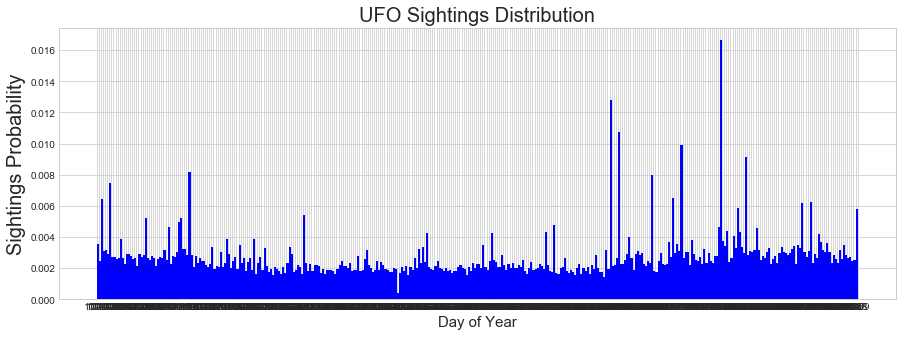

In [207]:
#Is there some significant Day? 
df.Month_Day.hist(bins=365, color='blue', normed=True, figsize=(15,5))
plt.xlabel('Day of Year', fontsize =15)
#plt.xlim(1940,2014)
plt.ylabel("Sightings Probability", fontsize=(20))
plt.title("UFO Sightings Distribution", fontsize =20)
plt.show()

In [208]:
#Some significant days above look to be 4th of July, New Years Day & Eve, Halloween, Flag Day
df.Month_Day.value_counts().nlargest(15)

07-04    1121
06-01     863
06-15     726
07-15     670
08-15     615
01-01     551
06-30     540
10-15     502
07-01     439
10-01     434
09-15     420
09-01     418
08-01     397
12-31     363
10-31     353
Name: Month_Day, dtype: int64

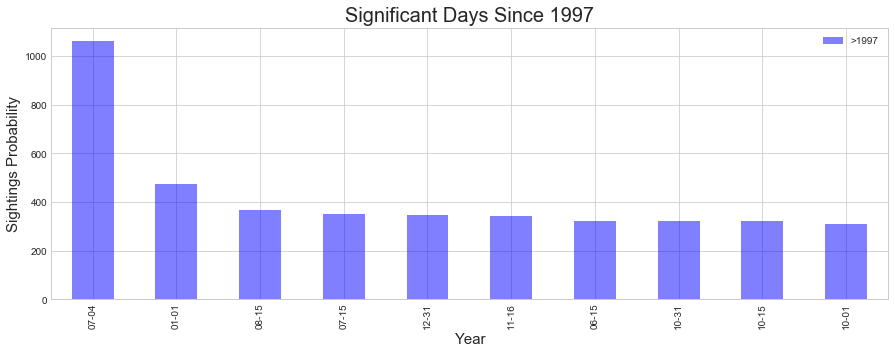

In [194]:
#Looking at significant Days, it seems 4th of July is by far the most popular day for sightings with other holidays mixed in
df[df.Year >= 1997]['Month_Day'].value_counts().nlargest(10)\
.plot(kind='bar',color='blue', alpha=0.5, label=">1997", legend=True, figsize=(15,5))
plt.xlabel('Year', fontsize =15)
plt.title("Significant Days Since 1997", fontsize =20)
plt.ylabel("Sightings Probability", fontsize=15)
plt.show()

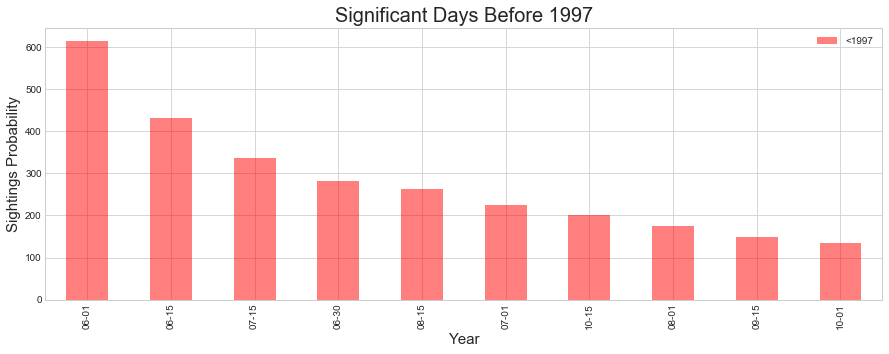

In [195]:
#Looking at significant Days 4th of July is not in the top 10, nor is any other US holiday
df[df.Year <= 1997]['Month_Day'].value_counts().nlargest(10)\
.plot(kind='bar',color='red', alpha=0.5, label="<1997", legend=True, figsize=(15,5))
plt.xlabel('Year', fontsize =15)
plt.title("Significant Days Before 1997", fontsize =20)
plt.ylabel("Sightings Probability", fontsize=15)
plt.show()

In [200]:
#From the 1910 (the first sighting) to the spike in sightings from 1997, 4th of July does not appear once as most frquent sightings day of that year.
df[df.Year < 1997].groupby('Year').apply(lambda x: x.groupby('Year')['Month_Day'].value_counts().nlargest(1))

Year    Year    Month_Day
1910.0  1910.0  05-28         1
1920.0  1920.0  06-11         1
1925.0  1925.0  12-28         1
1929.0  1929.0  07-05         1
1930.0  1930.0  06-30         1
1931.0  1931.0  02-15         1
1934.0  1934.0  09-15         1
1936.0  1936.0  07-15         1
1937.0  1937.0  08-15         1
1939.0  1939.0  06-01         1
1941.0  1941.0  06-01         1
1942.0  1942.0  02-25         1
1943.0  1943.0  10-15         1
1944.0  1944.0  01-01         1
1945.0  1945.0  06-01         1
1946.0  1946.0  06-30         2
1947.0  1947.0  07-15         7
1948.0  1948.0  04-30         1
1949.0  1949.0  08-15         3
1950.0  1950.0  06-30         3
1951.0  1951.0  06-30         2
1952.0  1952.0  06-30         6
1953.0  1953.0  08-15         3
1954.0  1954.0  06-01         6
1955.0  1955.0  06-01         4
1956.0  1956.0  06-15         8
1957.0  1957.0  07-15         7
1958.0  1958.0  06-01         5
1959.0  1959.0  06-15         4
1960.0  1960.0  06-01         6
1961.0  1961.0

In [78]:
#Only recent (2008) 4th of July appears as most frequent sighting day (5/7) years in the data set
df[df.Year > 1997].groupby('Year').apply(lambda x: x.groupby('Year')['Month_Day'].value_counts().nlargest(1))

Year    Year    Month_Day
1998.0  1998.0  09-23         35
1999.0  1999.0  11-16        160
2000.0  2000.0  07-07         28
2001.0  2001.0  11-18         46
2002.0  2002.0  08-10         31
2003.0  2003.0  11-08         46
2004.0  2004.0  10-31         86
2005.0  2005.0  09-30         56
2006.0  2006.0  10-01         45
2007.0  2007.0  12-10         37
2008.0  2008.0  07-04         56
2009.0  2009.0  09-19        111
2010.0  2010.0  07-04        186
2011.0  2011.0  07-04        140
2012.0  2012.0  07-04        174
2013.0  2013.0  07-04        160
2014.0  2014.0  01-01         93
Name: Month_Day, dtype: int64

In [197]:
#Average sightings per day
df.groupby('Year')['Month_Day'].value_counts().mean()

6.962003097573567

In [198]:
#Average sightings on 4th of July
df[df.Month_Day == '07-04'].groupby('Year')['Month_Day'].value_counts().mean()

25.477272727272727

## Mangerial Suggestion 

Since the 1997/1998 spike, ufo sightings occur most frequently on US holidays, were 4th of July is the highest.This can be coincidental, however 4th July nor any other major US Holiday show up once as a most frquent sighting day of the year before 1997. Instead the most popular day was 06/01, which showed up 29/66 years. This could indicate a possible trend that UFO sightings are on the rise for on particular days, more spefically US holidays after 1997. Researchers and ufologist should  place more emphasis on US holidays to increase probability of capturing a ufo sighting.